## **0. Environment Setup & Dependency Resolution**

### **Objective**
The default Kaggle environment comes with pre-installed libraries (like `numpy` 2.0+) that are currently incompatible with `ultralytics` and `lightly`. Standard `!pip install` commands often fail because system paths prioritize the pre-installed (broken) versions.

### **The Solution: Isolated Environment**
To bypass these conflicts, this cell implements a robust "Target Directory" fix:
1.  **Create Custom Directory:** We create a private folder at `/kaggle/working/my_env`.
2.  **Force Installation:** We install stable, compatible versions of `numpy` (1.x), `scipy` (1.13.1), and our project tools (`ultralytics`, `lightly`) directly into this folder.
3.  **Path Injection:** We insert this folder at the **top** of Python's system path (`sys.path`), forcing the notebook to load our working libraries instead of the system defaults.

**Expected Outcome:**
* Numpy version should be `1.26.x`.
* SciPy version should be `1.13.1`.
* This ensures `SimCLR` training runs without "AttributeError" crashes.


In [1]:
import os
import sys
import subprocess

# 1. Create a folder for our custom libraries
# We install here so Kaggle's system libraries can't mess with us
TARGET_DIR = "/kaggle/working/my_env"
if not os.path.exists(TARGET_DIR):
    os.makedirs(TARGET_DIR)

# 2. Add this folder to the VERY TOP of the system path
# This forces Python to load our working libraries before the broken system ones
if TARGET_DIR not in sys.path:
    sys.path.insert(0, TARGET_DIR)

# 3. Force Install Stable Versions into that folder
# We exclude 'torch' to save download time (system torch usually works with numpy 1.x)
print("🚀 Installing stable libraries into private environment... (This takes ~2 mins)")
subprocess.check_call([
    sys.executable, "-m", "pip", "install",
    "--target", TARGET_DIR,  # Install into our folder
    "numpy<2.0",             # Force Numpy 1.x
    "scipy==1.13.1",         # Force Stable SciPy
    "ultralytics",
    "lightly",
    "pytorch-lightning",
    "--upgrade",
    "--no-user"              # Ignore user's home directory
])

print("\n✅ Installation Complete. Verifying versions...")
import numpy
import scipy
print(f"🔹 Numpy Version: {numpy.__version__} (Should be 1.26.x)")
print(f"🔹 SciPy Version: {scipy.__version__} (Should be 1.13.1)")


🚀 Installing stable libraries into private environment... (This takes ~2 mins)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 9.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires fsspec[http]<=2025.10.0,>=2023.1.0, but you have fsspec 2025.12.0 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.8 which is incompatible.
s3fs 2025.3.0 requires fsspec==2025.3.0.*, but you have fsspec 2025.12.0 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but yo


✅ Installation Complete. Verifying versions...
🔹 Numpy Version: 1.26.4 (Should be 1.26.x)
🔹 SciPy Version: 1.13.1 (Should be 1.13.1)


In [2]:
# Remove the problematic logging library entirely
!pip uninstall -y tensorboard


Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


# **CSE 475: Phase 1 - Self-Supervised Learning (SimCLR) for SylFish_BD**

## **1. Objective**
This notebook implements the **SimCLR (Contrastive Learning)** pipeline.
* **Goal:** Pre-train the **YOLOv12n Backbone** on unlabeled data.
* **Input:** 80% Unlabeled images from the SylFish_BD dataset.
* **Output:** Learned weights (`yolo_simclr_backbone.pth`) that understand visual features.

## **2. Dataset**
We use the SylFish_BD dataset (9 fish species: boal, ilish, kalibaush, katla, koi, mrigel, pabda, rui, telapia). We will only use the **images** and ignore the labels for this phase.


In [3]:
import sys
import os
from pathlib import Path
import shutil
import glob

# --- 1. RECONNECT TO CUSTOM ENVIRONMENT ---
# We must run this block every time we restart the kernel
TARGET_DIR = "/kaggle/working/my_env"
if TARGET_DIR not in sys.path:
    sys.path.insert(0, TARGET_DIR)

print(f"✅ Connected to custom environment at: {TARGET_DIR}")

# --- 2. NOW IMPORT LIBRARIES ---
# Since Python now knows where to look, these imports will work
import torch
import pytorch_lightning as pl
import lightly
import ultralytics

print("✅ All libraries imported successfully!")

# --- 3. LOAD DATA FROM KAGGLE INPUT ---
# SylFish_BD dataset is available at /kaggle/input/syfish-bd/Sylfish_bd
input_dir = Path('/kaggle/input/syfish-bd/Sylfish_bd')
images_dir = input_dir / 'images'

# Create unlabeled directory (80% of images)
UNLABELED_DIR = '/kaggle/working/ssl_experiment/unlabeled_data/images'
os.makedirs(UNLABELED_DIR, exist_ok=True)

# Collect all images from all fish species
classes = ['boal', 'ilish', 'kalibaush', 'katla', 'koi', 'mrigel', 'pabda', 'rui', 'telapia']
all_images = []

for cls in classes:
    cls_dir = images_dir / cls
    if cls_dir.exists():
        images = list(cls_dir.glob('*.jpg'))
        all_images.extend(images)
        print(f"   Found {len(images)} images in {cls}")

print(f"\n✅ Total images collected: {len(all_images)}")

# Copy 80% of images to unlabeled directory (for SimCLR)
import random
random.seed(42)
random.shuffle(all_images)
unlabeled_count = int(len(all_images) * 0.8)
unlabeled_images = all_images[:unlabeled_count]

print(f"📊 Using {len(unlabeled_images)} images (80%) for SimCLR pre-training...")

# Copy images to unlabeled directory
for img_path in unlabeled_images:
    shutil.copy(img_path, UNLABELED_DIR)

print(f"✅ Data Ready at: {UNLABELED_DIR}")
print(f"✅ Total unlabeled images: {len(os.listdir(UNLABELED_DIR))}")


✅ Connected to custom environment at: /kaggle/working/my_env
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ All libraries imported successfully!
   Found 885 images in boal
   Found 789 images in ilish
   Found 525 images in kalibaush
   Found 1133 images in katla
   Found 592 images in koi
   Found 1293 images in mrigel
   Found 862 images in pabda
   Found 1670 images in rui
   Found 1326 images in telapia

✅ Total images collected: 9075
📊 Using 7260 images (80%) for SimCLR pre-training...
✅ Data Ready at: /kaggle/working/ssl_experiment/unlabeled_data/images
✅ Total unlabeled images: 7260


## **3. YOLO-SimCLR Model Architecture**

This cell defines the custom PyTorch Lightning module **`YoloSimCLR`**, which adapts the YOLOv12 architecture for contrastive learning. It performs the following key operations:

### **3.1 Warning Suppression**
* **Purpose:** The code first suppresses specific `UserWarnings` related to `pydantic`.
* **Reason:** The `lightly` and `ultralytics` libraries use metadata attributes (`repr`, `frozen`) in a way that generates harmless but noisy warnings in the current Kaggle environment. Silencing them keeps the training logs clean.

### **3.2 Model Surgery (Backbone Extraction)**
* **Loading:** We initialize a standard `yolov12n.pt` model.
* **Extraction:** We surgically extract the **first 10 layers** (indices 0-9) of the model. This corresponds to the **CSP-Darknet Backbone**, which is responsible for feature extraction (edges, textures, shapes). The detection head is discarded.

### **3.3 The "Shape Fix" (Adaptive Pooling)**
* **The Problem:** YOLO backbones output multi-scale feature maps (e.g., `256 x 20 x 20`). Passing this directly to a linear layer often causes shape mismatch errors (e.g., `mat1 and mat2 shapes cannot be multiplied`).
* **The Solution:** We insert an `nn.AdaptiveAvgPool2d((1, 1))` layer.
* **Effect:** This forces the spatial dimensions to `1x1` regardless of the input size, flattening the features into a clean vector (e.g., `[Batch, 256]`). This guarantees compatibility with the projection head.

### **3.4 SimCLR Components**
* **Projection Head:** A multi-layer perceptron (MLP) that maps the backbone features into a 128-dimensional latent space.
* **Loss Function:** We use **NT-Xent Loss** (Normalized Temperature-scaled Cross Entropy), which forces the model to pull positive pairs (two views of the same image) closer together while pushing negative pairs apart.


In [4]:
import warnings

# Suppress specific Pydantic warnings to keep the output clean
warnings.filterwarnings("ignore", message="The 'repr' attribute with value False")
warnings.filterwarnings("ignore", message="The 'frozen' attribute with value True")
print("✅ Pydantic warnings silenced.")


✅ Pydantic warnings silenced.


In [5]:
import torch
import torch.nn as nn
from ultralytics import YOLO
import pytorch_lightning as pl
from lightly.models.modules import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class YoloSimCLR(pl.LightningModule):
    def __init__(self, model_name='yolo12n.pt'):
        super().__init__()
        # 1. Load YOLO
        yolo = YOLO(model_name)
        
        # 2. Extract Backbone (Layers 0-9)
        self.backbone = nn.Sequential(*list(yolo.model.model.children())[:10])
        
        # 3. Add Global Average Pooling (THE FIX)
        # This crushes spatial dimensions (H, W) -> (1, 1)
        # Guarantees the output vector size is just 'Channels' (e.g., 512 or 256)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 4. Check actual channel count
        with torch.no_grad():
            dummy = torch.randn(1, 3, 640, 640)
            out = self.backbone(dummy)
            if isinstance(out, list): out = out[-1]
            
            # Now we pool it to see the channel count
            pooled = self.avg_pool(out)
            in_features = pooled.flatten(1).shape[1]
            print(f"✅ Detected Backbone Channels: {in_features}")
            
        # 5. Projection Head
        self.projection_head = SimCLRProjectionHead(in_features, 512, 128)
        self.criterion = NTXentLoss()

    def forward(self, x):
        # Backbone Forward
        features = self.backbone(x)
        if isinstance(features, list): features = features[-1]
        
        # Pool & Flatten
        pooled = self.avg_pool(features)
        h = pooled.flatten(start_dim=1)
        
        # Project
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss", loss, prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.08, momentum=0.9)

print("✅ Fixed YOLO-SimCLR Model Defined")


✅ Fixed YOLO-SimCLR Model Defined


## **4. SimCLR Training Execution**

This cell executes the self-supervised pre-training loop. It consists of three key stages:

### **4.1 Logging & Environment Setup**
* **Warning Suppression:** We filter out specific `UserWarnings` and `BrokenPipe` errors common in distributed training on Jupyter notebooks. This ensures the output remains readable without affecting training stability.

### **4.2 Data Augmentation & Loading**
* **SimCLR Transform:** We rely on `lightly.transforms.SimCLRTransform` to automatically generate two augmented views for every image. Augmentations include random cropping, color jittering, and Gaussian blur.
* **DataLoader:** Configured for **2x T4 GPUs** with a batch size of 1024 (effective batch size = 2048).

### **4.3 Model Training**
We initialize the `YoloSimCLR` model and train it using the `PyTorch Lightning` Trainer with specific optimizations:
* **`strategy="ddp_notebook"`:** Enables Distributed Data Parallel training compatible with interactive kernels.
* **`sync_batchnorm=True`:** Synchronizes Batch Normalization statistics across both GPUs. This is **critical for Contrastive Learning**, as it prevents the model from using local batch statistics to "cheat" the contrastive task.
* **`precision="16-mixed"`:** Uses Mixed Precision training to reduce VRAM usage and speed up computations on T4 GPUs.

**Output:** The script saves the learned backbone weights to `yolo_simclr_backbone.pth`.


In [6]:
import warnings
import logging
import os

# 1. Suppress PyTorch Lightning & Distributed Warnings
os.environ["TORCH_CPP_LOG_LEVEL"] = "ERROR"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "OFF"

# 2. Filter Python Warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Specific filters for the Pydantic/Tensorboard noise
warnings.filterwarnings("ignore", message=".*'repr' attribute.*")
warnings.filterwarnings("ignore", message=".*'frozen' attribute.*")
warnings.filterwarnings("ignore", message=".*support for historical reasons.*")

# 3. Mute Library Loggers
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("torch.distributed").setLevel(logging.ERROR)
logging.getLogger("ultralytics").setLevel(logging.ERROR)

print("✅ Warnings suppressed.")


✅ Warnings suppressed.


In [7]:
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.data import LightlyDataset
from torch.utils.data import DataLoader
import os

# 1. Setup Transforms
# 128x128 is safe for this massive batch size. 
# If you crash with OOM, reduce batch_size to 512.
transform = SimCLRTransform(input_size=128) 

# 2. Load Dataset
# Ensure UNLABELED_DIR is defined (e.g. from your data download cell)
if 'UNLABELED_DIR' not in locals():
    # Fallback if variable is lost
    print("⚠️ Finding dataset path...")
    import glob
    UNLABELED_DIR = '/kaggle/working/ssl_experiment/unlabeled_data/images'
    if not os.path.exists(UNLABELED_DIR):
        possible_dirs = glob.glob("/kaggle/working/**/unlabeled_data/images", recursive=True)
        UNLABELED_DIR = possible_dirs[0] if possible_dirs else "ERROR_PATH_NOT_FOUND"

dataset = LightlyDataset(input_dir=UNLABELED_DIR, transform=transform)

# 3. Create DataLoader (Optimized)
dataloader = DataLoader(
    dataset, 
    batch_size=2048,         
    shuffle=True, 
    num_workers=2,           # Max 2 workers per GPU on Kaggle
    drop_last=True,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Data Loader Ready. Effective Batch Size: 2048")


✅ Data Loader Ready. Effective Batch Size: 2048


In [8]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Setup Logger
working_dir = os.getcwd()
logger = CSVLogger(save_dir=working_dir, name="simclr_logs")

print("🚀 Starting SimCLR Training (Batch 2048, 50 Epochs)...")

# 2. Initialize
model = YoloSimCLR(model_name='yolo12n.pt')

# 3. Train
trainer = pl.Trainer(
    max_epochs=30,           
    accelerator="gpu", 
    devices=2,               
    strategy="ddp_notebook", 
    sync_batchnorm=True,     
    precision="16-mixed",    # Critical for large batches to save memory
    log_every_n_steps=1,     
    logger=logger,
    enable_progress_bar=True
)

try:
    trainer.fit(model, dataloader)
    
    # 4. Save Weights
    save_path = os.path.join(working_dir, 'yolo_simclr_backbone.pth')
    torch.save(model.backbone.state_dict(), save_path)
    print(f"✅ Weights Saved: {save_path}")

except Exception as e:
    print(f"❌ Training Failed: {e}")
    print("   (If OOM occurs, reduce batch_size in Cell 2 to 512)")


🚀 Starting SimCLR Training (Batch 2048, 50 Epochs)...
✅ Detected Backbone Channels: 256


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone        │ Sequential           │  1.4 M │ train │     0 │
│ 1 │ avg_pool        │ AdaptiveAvgPool2d    │      0 │ train │     0 │
│ 2 │ projection_head │ SimCLRProjectionHead │  197 K │ train │     0 │
│ 3 │ criterion       │ NTXentLoss           │      0 │ train │     0 │
└───┴─────────────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 197 K                                                                                            
Non-trainable params: 1.4 M                                                                                        
Total params: 1.6 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 12                                                                                          
Modules in eval mode: 243                                                                                          
Total FLOPs: 0

Output()

✅ Weights Saved: /kaggle/working/yolo_simclr_backbone.pth


## **Appendix: Visual Verification (Sanity Check)**

### **Objective**
Since Self-Supervised Learning (SSL) does not use labels, we cannot evaluate it using standard metrics like Accuracy or mAP during the pre-training phase. Instead, we perform a **Qualitative Evaluation** using **Nearest Neighbor Retrieval**.

**The Hypothesis:** If the SimCLR backbone has successfully learned to "see" visual features (shapes, textures, orientations), then images that look similar to humans should have mathematically similar feature vectors (embeddings).

### **Methodology**
1.  **Feature Extraction:** We pass a random subset of 200 images through our frozen, pre-trained YOLOv12 backbone. We use **Global Average Pooling** to squash the output into a single 1D vector (embedding) for each image.
2.  **Similarity Search:** We use the **k-Nearest Neighbors (k-NN)** algorithm with **Cosine Similarity** to find images in the dataset that are closest to a given query image in the embedding space.
3.  **Visualization:** We display the **Query Image** alongside its top 3 **Matches**.

### **How to Interpret Results**
* **✅ Success:** The matches share semantic characteristics with the query (e.g., similar fish species match together, or similar lighting conditions match). This proves the model has learned a structured representation space.
* **❌ Failure:** The matches appear completely random. This typically indicates that the model needs more training epochs.


📂 Checking image directory: /kaggle/working/ssl_experiment/unlabeled_data/images
✅ Found 7260 images.
🔄 Loading Backbone...
✅ Weights Loaded!
📊 Extracting features from 200 images...
   Processed 0...
   Processed 50...
   Processed 100...
   Processed 150...
✅ Extracted features shape: (200, 256)
🔍 Finding matches...


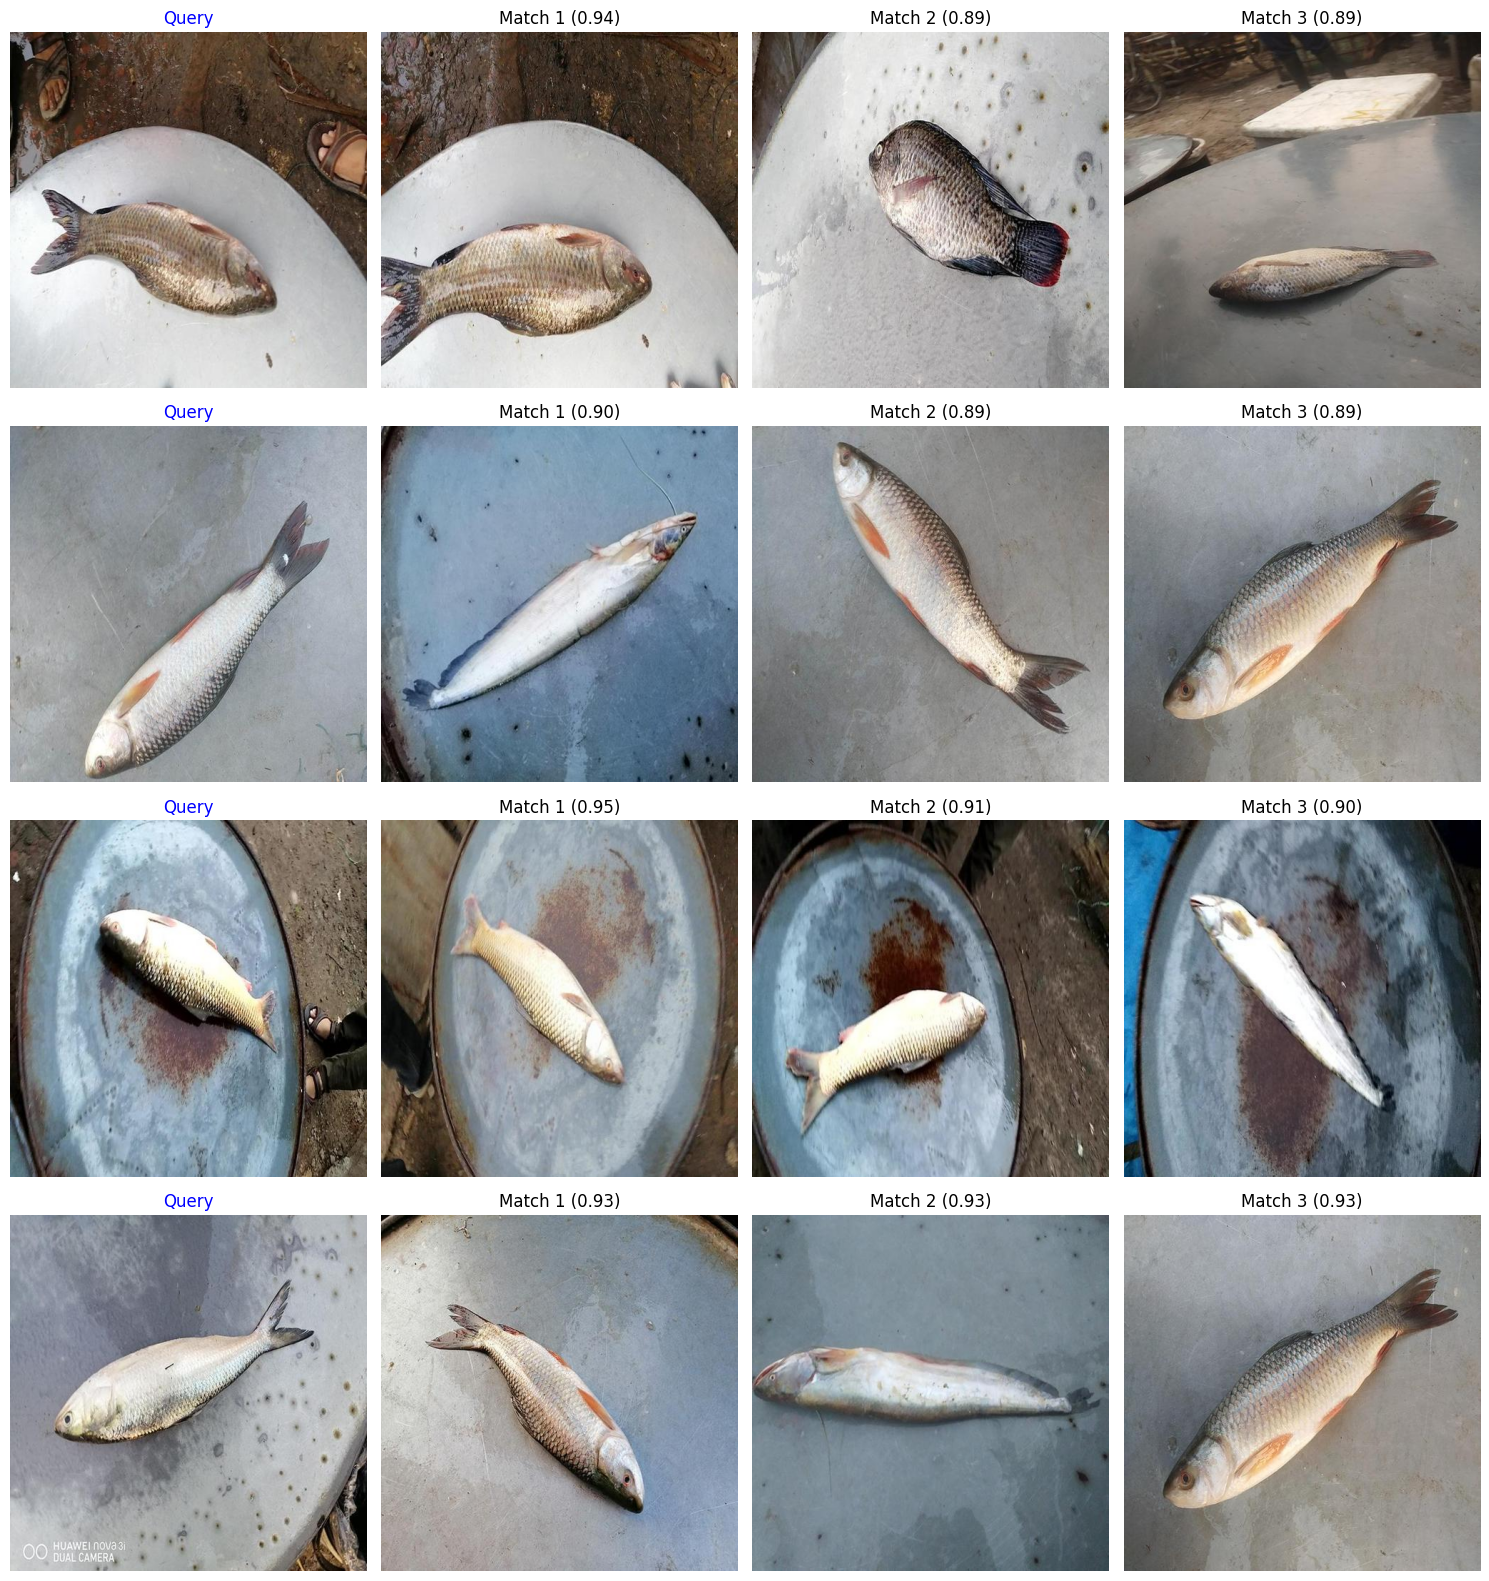

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random
from PIL import Image
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors
from ultralytics import YOLO

# --- CONFIGURATION ---
WEIGHTS_PATH = 'yolo_simclr_backbone.pth'
# Double check this path exists!
IMAGE_DIR = '/kaggle/working/ssl_experiment/unlabeled_data/images'
NUM_SAMPLES = 200
NUM_QUERIES = 4

# 1. Verify Data Exists First
print(f"📂 Checking image directory: {IMAGE_DIR}")
if not os.path.exists(IMAGE_DIR):
    print(f"❌ Error: Directory does not exist. Did you run the 'prepare_data' step?")
    # Try to find where the images actually are
    print("🔍 Searching for images in current directory...")
    found_imgs = glob.glob("**/*.jpg", recursive=True)
    if found_imgs:
        print(f"   Found images at: {os.path.dirname(found_imgs[0])}")
        IMAGE_DIR = os.path.dirname(found_imgs[0])
        print(f"   -> Updated IMAGE_DIR to: {IMAGE_DIR}")
    else:
        raise FileNotFoundError("No images found! You need to re-run the Data Download/Split step.")

image_files = glob.glob(os.path.join(IMAGE_DIR, '*'))
print(f"✅ Found {len(image_files)} images.")

if len(image_files) == 0:
    raise ValueError("Image directory is empty!")

# 2. Load Backbone
print("🔄 Loading Backbone...")
base_model = YOLO('yolo12n.pt')
backbone = torch.nn.Sequential(*list(base_model.model.model.children())[:10])

if os.path.exists(WEIGHTS_PATH):
    state_dict = torch.load(WEIGHTS_PATH)
    # Strict=False to ignore any potential head mismatches
    backbone.load_state_dict(state_dict, strict=False)
    print("✅ Weights Loaded!")
else:
    print("⚠️ Weights not found. Using random weights.")

backbone.eval()
backbone.to('cuda')

# 3. Extract Features (Debug Mode)
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

if len(image_files) > NUM_SAMPLES:
    image_files = random.sample(image_files, NUM_SAMPLES)

features = []
valid_files = []

print(f"📊 Extracting features from {len(image_files)} images...")

for i, img_path in enumerate(image_files):
    # No try-except block -> We want to see the error!
    img = Image.open(img_path).convert('RGB')
    tensor = preprocess(img).unsqueeze(0).to('cuda')

    with torch.no_grad():
        feat = backbone(tensor)
        if isinstance(feat, list): feat = feat[-1]

        # Adaptive pool to ensure 1x1 output regardless of input size
        feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
        feat = feat.flatten().cpu().numpy()

    features.append(feat)
    valid_files.append(img_path)

    if i % 50 == 0: print(f"   Processed {i}...")

features = np.array(features)
print(f"✅ Extracted features shape: {features.shape}")

# 4. Nearest Neighbors
if features.shape[0] < 5:
    print("❌ Not enough features to run neighbors search.")
else:
    print("🔍 Finding matches...")
    nbrs = NearestNeighbors(n_neighbors=4, metric='cosine').fit(features)
    query_indices = random.sample(range(len(features)), NUM_QUERIES)

    fig, axs = plt.subplots(NUM_QUERIES, 4, figsize=(15, 4 * NUM_QUERIES))
    for i, query_idx in enumerate(query_indices):
        distances, indices = nbrs.kneighbors([features[query_idx]])

        # Plot Query
        axs[i, 0].imshow(Image.open(valid_files[query_idx]))
        axs[i, 0].set_title("Query", color='blue')
        axs[i, 0].axis('off')

        # Plot Matches
        for j in range(1, 4):
            idx = indices[0][j]
            dist = distances[0][j]
            axs[i, j].imshow(Image.open(valid_files[idx]))
            axs[i, j].set_title(f"Match {j} ({1-dist:.2f})")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()
